In [1]:
include("../code/julia/ha-trade-environment.jl")
include("../code/julia/ha-trade-solution.jl")
include("../code/julia/ha-trade-helper-functions.jl")
include("../code/julia/ha-trade-elasticity.jl")
include("../code/julia/ha-trade-efficient.jl")
include("../code/julia/static-trade-environment.jl")
include("../code/julia/gravity-tools.jl")

using MINPACK
using Plots
using CSV
using DataFrames

### Overview

This notebook provides an introductory / high-level look into how things in the HAT model operate in a two country environment.

---

### Set Parameters

Parameters are subdivided into two groups. One relates specifically to households, then the second relates to country-specific and/or aggregate things. I use keyword structures (as shown below) to construct these values.

In [2]:
γ = 1.5 # curvatuve on CRRA utility function
σϵ = 0.25 # logit dispersion parameter
Ncntry = 2 # number of countries

# this setups up parameters on the household side
hh_prm = household_params(Ncntry = Ncntry, Na = 100, β = 0.92, γ = γ, ϕ = 0.5, amax = 8.0, σϵ = σϵ);


In [3]:
# here are some simpe country parametrers
TFP = [1.0; 1.0]

L = [1.0; 1.0]

d_ij = 2.05

d = [1.0 d_ij; d_ij 1.0]

# this sets up the country specific paramters
cntry_prm = country_params(Ncntry = Ncntry, L = L, d = d, TFP = TFP);

---

### Find an equilibrium 

Does what it says. Here I'm computing one for financial globalization. 

In [14]:
f(x) = world_equillibrium_FG(exp.(x), hh_prm, cntry_prm)
# this world... function is used to construct zero conditions for
# the finacial globalization case

function f!(fvec, x)

    fvec .= f(x)

end


xguess = [1.0; 1.02]

n = length(xguess)
diag_adjust = n - 1

sol = fsolve(f!, log.(xguess), show_trace = true, method = :hybr;
      ml=diag_adjust, mu=diag_adjust,
      diag=ones(n),
      mode= 1,
      tol=1e-10,
       )

# This solver works very well in general. Spencer Lyon converted old-school minpack
# routines in C into julia

print(sol)

wage = [exp.(sol.x[1]); 1.0]
R = exp.(sol.x[2])

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     1.403723e-01     0.000000e+00         0.123000
     2     1.213201e-02     2.202805e-05         0.389000
     3     1.259896e-03     3.736354e-07         0.117000
     4     4.993984e-06     5.654746e-09         0.220000
     5     6.468239e-08     1.225985e-13         0.119000
     6     1.217343e-09     1.242072e-17         0.117000
     7     1.918979e-12     4.420608e-21         0.144000
     8     1.512679e-15     1.102417e-26         0.102000
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [0.0, 0.01980262729617973]
 * Zero: [-2.539334916897248e-9, 0.014658455660138943]
 * Inf-norm of residuals: 0.000000
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at most tol
 * Total time: 1.331000 seconds
 * Function Calls: 8
 * Jacobian Calls (df/dx): 1

1.0147664176951972

Then here are the results. The first entry is the wage rate which should be 1.0 given the symmetry. The second price is the interest rate, here it should be around 1.5 percent.

In [5]:
println(exp.(sol.x))


[0.999999997460665, 1.0147664176951972]


Then this call computes aggregates given prices

In [6]:
Rsol = [R; R]

Y, tradeflows, A_demand, tradeshare, hh, dist = world_equillibrium(Rsol, wage, hh_prm, cntry_prm, tol_vfi = 1e-10);

# this world_eq...is a core file takes prices and returns a bunch of stuff
# note that hh, dist are objects of dimensiom number of countries, then within
# it has policy functions and distributions state by state

Here we can see the trade share matrix. Importers are rows, columns are exporters. So Country 1 (aggregate) expenditure share is about 10 percent

In [7]:
tradeshare

2×2 Matrix{Float64}:
 0.900776   0.0992245
 0.0992245  0.900776

Then just to highlight how this works a bit. We can unpack the stuff under this. So here are the state by state choice probabilities of households in country 1. And then one can see how poor people don't buy much, rich people buy more. 

In [8]:
hh[1].πprob[:,:,2]
# guys in country one, a X z, probability of buying from 2

100×10 Matrix{Float64}:
 0.00138678  0.00993352  0.00537662  …  0.102444  0.0767857  0.147694
 0.00327247  0.0146069   0.00843019     0.105558  0.0898392  0.148827
 0.0112065   0.0207552   0.0167765      0.108524  0.103707   0.149906
 0.0152813   0.0248412   0.0277783      0.111233  0.118308   0.150934
 0.0215474   0.0278565   0.0337028      0.11344   0.130242   0.151889
 0.0251714   0.0315868   0.0399355   …  0.115381  0.133943   0.152781
 0.0282926   0.0347306   0.0434485      0.117122  0.136791   0.153635
 0.0320416   0.037364    0.0478014      0.118718  0.139432   0.154454
 0.0350295   0.0398928   0.0519537      0.120238  0.141944   0.155237
 0.0376429   0.0423808   0.0544755      0.121656  0.144225   0.155997
 0.0402284   0.0447331   0.0571077   …  0.122976  0.145714   0.156734
 0.0426967   0.0469303   0.0598945      0.124233  0.147035   0.15745
 0.044985    0.0490275   0.0625202      0.125437  0.148228   0.158145
 ⋮                                   ⋱                       
 0.12

---

### Compute Elasticities

Delivering heterogeneity in price sensitivity is a core issue in my model. Here I illustrate this. 

Here is what I'm going to do, given the equilibrium prices, I'm going to construct the trade elasticities and aggregate up, per Proposition 3 in the paper. The first step is to reconstruct the household for one country, evaluate how things change at the micro-level, then appropriately aggregate. 


In [9]:
cntry = 1 # this is the country I'll look at

p = (wage[1:end] ./ TFP).*d[cntry,:] 
# prices from the perspective of those in that country

hh = solve_household_problem(R, wage[cntry], p, hh_prm, tol = 1e-10);
# solve hh problem at those prices

dist = make_stationary_distribution(hh, hh_prm);
# find stationary distribution


This cell below then constructs the elasticities via numerical differentiation. Then the last two function calls construct the weights and then aggregate.

A note on accuracy. I don't have a closed form for this. But in Mongey and Waugh, we do. And their I found that this approach worked well with the only issues being around states where the household is about to leave the borrowing constraint. This is to be expected per my discussion in the paper regarding how the constraint might show up in the elasticities.

In [10]:
θ = make_θ(cntry, R, wage[cntry], p, hh_prm; points = 3, order = 1)
# makes the micro elasticities for country, cntry, 

ω = make_ω(hh, dist, L[cntry], p, hh_prm)
# makes the expenditure weights

agθ = aggregate_θ(θ, ω, cntry, hh_prm)
# construct the aggregate elasticity. The interesting element here is 
# agθ[cntry]

2-element Vector{Float64}:
  1.0
 -3.2047965032383434

**A quick tour of the results:**

The second element above is the aggregate trade elasticity. In this situation it's about 3. What if the trade costs was larger?

Then we can look at the **micro-elasticities**. 

The θ is a structure and contains the intensive margin, extensive margin, and how home stuff changes with respect to a change in prices. The first one is how θ_{ij}^E looks state by state (assets are rows, income shocks are columns) where one see high extensive margin elasticities for stuff in the upper-left corner of the matrix (poor people) and then in the lower-right corner the elasticities are low (rich people)

In [11]:
θ.θπ[:,:,2]

100×10 Matrix{Float64}:
 -10.8934   -8.58827  -8.60868  -5.62986  …  -3.13691  -4.09316  -2.36795
  -9.5095   -6.7905   -7.83779  -5.42986     -3.06879  -3.91746  -2.35831
  -8.47907  -6.42619  -7.24191  -4.93144     -3.02348  -3.74055  -2.34324
  -6.74528  -5.76474  -5.63593  -4.81198     -2.97719  -3.59711  -2.32786
  -6.38552  -5.57691  -5.4216   -4.62256     -2.93131  -2.66325  -2.30876
  -5.74669  -5.40675  -4.92617  -4.52453  …  -2.88234  -2.65167  -2.29272
  -5.55616  -5.14219  -4.80677  -4.32338     -2.83299  -2.5683   -2.27932
  -5.38947  -5.0023   -4.6184   -4.24151     -2.79889  -2.56076  -2.26696
  -5.1298   -4.90868  -4.52068  -4.14381     -2.77137  -2.53213  -2.2588
  -4.99102  -4.78308  -4.32095  -4.0744      -2.75662  -2.48546  -2.24787
  -4.89707  -4.6595   -4.23884  -3.97934  …  -2.73167  -2.41391  -2.23776
  -4.7724   -4.56634  -4.14098  -3.91908     -2.70784  -2.38572  -2.22761
  -4.65201  -4.50025  -4.07168  -3.86055     -2.68514  -2.36353  -2.21775
   ⋮           

Then one sees the same thing on the **intensive margin**. Constrained guys have intensive margin elasticities of -1. Then as you get richer, these elasticities fall. The wavy action as one moves across shocks is because of the ordering on the permanent and transitory components of the shocks

In [12]:
θ.θc[:,:,2]

100×10 Matrix{Float64}:
 -1.0       -1.0       -1.0       …  -0.743259  -1.0       -0.695148
 -1.0       -0.838934  -1.0          -0.729997  -1.0       -0.694951
 -1.0       -0.837329  -1.0          -0.720411  -1.0       -0.693228
 -0.838728  -0.776077  -0.83302      -0.716605  -1.0       -0.691692
 -0.837157  -0.769424  -0.831746     -0.715124  -0.744279  -0.689886
 -0.775927  -0.767771  -0.780573  …  -0.710149  -0.745326  -0.688457
 -0.769219  -0.746291  -0.77769      -0.705144  -0.721004  -0.687277
 -0.767585  -0.739633  -0.763699     -0.701618  -0.719008  -0.686241
 -0.746213  -0.738959  -0.762743     -0.698856  -0.715405  -0.686264
 -0.739551  -0.733088  -0.739243     -0.698997  -0.712029  -0.685421
 -0.738882  -0.725571  -0.734932  …  -0.696328  -0.702274  -0.684717
 -0.732962  -0.721386  -0.729358     -0.694443  -0.698124  -0.684058
 -0.725521  -0.720905  -0.728325     -0.692824  -0.695054  -0.683435
  ⋮                               ⋱                        
 -0.67107   -0.6709

### Assets

This gives a sense of the distribution of assets in the model. Here the constraint is quite tight and with the permanent + transitory shocks there is a large number of constrained individuals in this economy. 

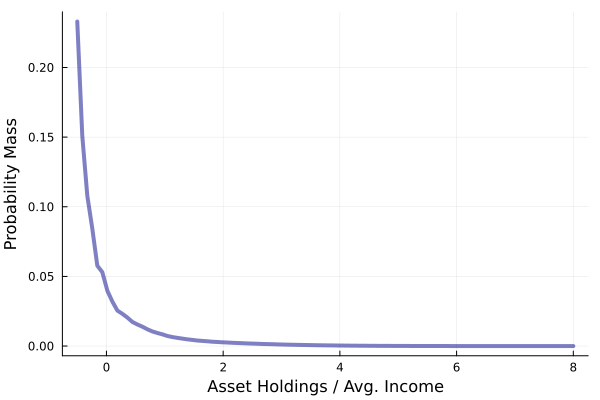

In [13]:
adist = get_distribution(dist.state_index, dist.λ);

plot(hh_prm.agrid , adist, alpha = 0.5, lw = 4,
    color = "dark blue", ylabel = "Probability Mass", 
    xlabel = "Asset Holdings / Avg. Income", label = false)